In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

Upload the labels.csv and processed_counts.csv files to colab or your local workspace.

**Copied from Part 1:**
This data associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

In [ ]:
labels_pd = pd.read_csv("labels.csv")
counts_pd = pd.read_csv("processed_counts.csv")

In [ ]:
labels_pd.index = labels_pd['index']
labels_pd.drop("index", axis=1, inplace=True)
counts_pd.index = counts_pd['Unnamed: 0']
counts_pd.drop("Unnamed: 0", axis=1, inplace=True)

df = counts_pd.merge(labels_pd, left_index=True, right_index=True).dropna()
df

,HES4,TNFRSF4,SSU72,PARK7,RBP7,SRM,MAD2L2,AGTRAP,TNFRSF1B,EFHD2,...,MRPS6,TTC3,U2AF1,CSTB,SUMO3,ITGB2,S100B,PRMT2,MT-ND3,bulk_labels
AAAGCCTGGCTAAC-1,-0.326,-0.191,-0.728,-0.301,3.386,-0.531,2.016,3.377,4.841,-0.525,...,-0.532,-0.341,0.303,1.404,4.294,0.519,-0.21,-0.636,4.011,CD14+ Monocyte
AAATTCGATGCACA-1,1.171,-0.191,0.795,-1.200,-0.174,-0.531,1.889,-0.486,-0.459,-0.525,...,-0.532,-0.341,-0.905,2.849,-0.585,1.172,-0.21,2.630,-0.490,Dendritic
AACACGTGGTCTTT-1,-0.326,-0.191,0.483,-1.200,-0.174,-0.531,-0.451,0.971,-0.459,2.286,...,2.606,-0.341,-0.905,-0.455,-0.585,0.722,-0.21,0.663,-0.490,CD56+ NK
AAGTGCACGTGCTA-1,-0.326,-0.191,1.134,-0.157,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,-0.905,-0.119,-0.585,0.766,-0.21,-0.636,-0.490,CD4+/CD25 T Reg
ACACGAACGGAGTG-1,-0.326,-0.191,-0.728,-0.607,-0.174,-0.531,-0.451,0.787,-0.459,1.932,...,0.839,1.679,-0.108,-0.534,-0.585,-0.007,-0.21,-0.636,-0.490,Dendritic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGGCACCTCCAACA-8,-0.326,-0.191,0.372,-0.584,-0.174,0.509,-0.451,2.160,-0.459,0.751,...,-0.532,1.758,1.578,0.055,-0.585,0.561,-0.21,0.543,2.593,Dendritic
TGTGAGTGCTTTAC-8,3.166,-0.191,-0.728,-1.200,-0.174,-0.531,-0.451,-0.486,-0.459,1.536,...,-0.532,-0.341,0.432,0.753,-0.585,-0.171,-0.21,1.268,-0.490,Dendritic
TGTTACTGGCGATT-8,-0.326,-0.191,-0.728,-1.200,-0.174,1.784,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,1.858,0.814,-0.585,0.152,-0.21,-0.636,1.226,CD4+/CD25 T Reg
TTCAGTACCGGGAA-8,-0.326,-0.191,-0.728,-0.386,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,2.378,0.420,0.888,-0.326,-0.21,-0.636,-0.490,CD19+ B


One-hot encode the cell-type.

Shuffle your data. Make sure your labels and the counts are shuffled together.

Split into train and test sets (80:20 split)

In [ ]:
categories = df['bulk_labels'].unique()
print(categories)

#one-hot encoding
y = np.zeros((len(df), len(categories)))
for i in range(len(df)):
  cell_type = df.iloc[i]['bulk_labels']
  pos = np.where(categories == cell_type)[0]
  y[i, pos] = 1

#remove label when processing input data
X = df.drop('bulk_labels', axis=1).values

#shufle and 80:20 split
np.random.seed(100)
permutation = np.random.permutation(len(X))
X, y = X[permutation], y[permutation]

X_train, y_train = X[:int(len(X)*0.8)], y[:int(len(y)*0.8)]
X_test, y_test = X[int(len(X)*0.8):], y[int(len(y)*0.8):]

['CD14+ Monocyte' 'Dendritic' 'CD56+ NK' 'CD4+/CD25 T Reg' 'CD19+ B'
 'CD8+ Cytotoxic T' 'CD4+/CD45RO+ Memory' 'CD8+/CD45RA+ Naive Cytotoxic'
 'CD4+/CD45RA+/CD25- Naive T' 'CD34+']


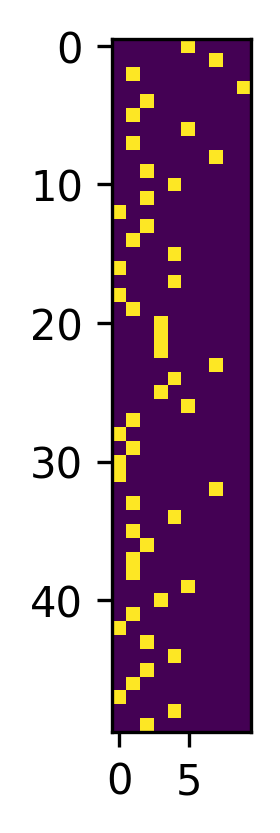

In [ ]:
#Visualize the One-hot encoded Prediction Labels
import matplotlib.pyplot as plt
plt.figure(figsize=(9,3), dpi=300)
plt.imshow(y_train[:50])

Apply classification algorithms to the training data, tune on validation data (if present), and evaluate on test data.

You can also apply classification downstream of last week's autoencoder latent space representation.

In [ ]:
#Model 1: Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Define the decision tree classifier
dtc = DecisionTreeClassifier()

# Compute 5-fold cross-validation
scores = cross_val_score(dtc, X_train, y_train, cv=5)

# Fit the decision tree classifier on the full training set
dtc.fit(X_train, y_train)

# Evaluate the decision tree classifier on the test set
test_score_dtc = dtc.score(X_test, y_test)

# Print the test set accuracy
print("Test set accuracy: %0.2f" % test_score_dtc)

Test set accuracy: 0.68


In [ ]:
#Model 2: Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Define the random forest classifier
rfc = RandomForestClassifier()

# Compute 5-fold cross-validation scores
scores = cross_val_score(rfc, X_train, y_train, cv=5)

# Fit the random forest classifier on the full training set
rfc.fit(X_train, y_train)

# Evaluate the random forest classifier on the test set
test_score_rfc = rfc.score(X_test, y_test)

# Print the test set accuracy
print("Test set accuracy: %0.2f" % test_score_rfc)

Test set accuracy: 0.61


In [ ]:
#Model 3: Feedforward Neural Networks

# Convert the data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train.astype(np.float32))
y_train_tensor = torch.from_numpy(y_train.astype(np.float32))
X_test_tensor = torch.from_numpy(X_test.astype(np.float32))
y_test_tensor = torch.from_numpy(y_test.astype(np.float32))

# Define the neural network
class FFNet(nn.Module):
    def __init__(self):
        super(FFNet, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 256)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(128, len(categories))

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = nn.functional.softmax(self.fc3(x), dim=1)
        return x

model = FFNet()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the neural network
for epoch in range(50):
    losses = 0.0
    for i, data in enumerate(DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32)):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, torch.max(labels, 1)[1])
        loss.backward()
        optimizer.step()
        losses += loss.item()
    print("Epoch %d, loss: %.3f" % (epoch + 1, losses / len(X_train)))

# Evaluate the neural network on the test set
outputs = model(X_test_tensor)
_, predicted = torch.max(outputs, 1)
total = y_test_tensor.size(0)
correct = (predicted == torch.max(y_test_tensor, 1)[1]).sum().item()
test_score_nn = correct / total
print("Test set accuracy: %0.2f" % test_score_nn)

Epoch 1, loss: 0.071
Epoch 2, loss: 0.060
Epoch 3, loss: 0.056
Epoch 4, loss: 0.054
Epoch 5, loss: 0.052
Epoch 6, loss: 0.051
Epoch 7, loss: 0.049
Epoch 8, loss: 0.049
Epoch 9, loss: 0.049
Epoch 10, loss: 0.049
Epoch 11, loss: 0.049
Epoch 12, loss: 0.049
Epoch 13, loss: 0.049
Epoch 14, loss: 0.049
Epoch 15, loss: 0.049
Epoch 16, loss: 0.049
Epoch 17, loss: 0.049
Epoch 18, loss: 0.048
Epoch 19, loss: 0.048
Epoch 20, loss: 0.048
Epoch 21, loss: 0.048
Epoch 22, loss: 0.048
Epoch 23, loss: 0.048
Epoch 24, loss: 0.048
Epoch 25, loss: 0.048
Epoch 26, loss: 0.048
Epoch 27, loss: 0.048
Epoch 28, loss: 0.047
Epoch 29, loss: 0.047
Epoch 30, loss: 0.047
Epoch 31, loss: 0.047
Epoch 32, loss: 0.047
Epoch 33, loss: 0.047
Epoch 34, loss: 0.047
Epoch 35, loss: 0.047
Epoch 36, loss: 0.047
Epoch 37, loss: 0.047
Epoch 38, loss: 0.047
Epoch 39, loss: 0.047
Epoch 40, loss: 0.047
Epoch 41, loss: 0.047
Epoch 42, loss: 0.047
Epoch 43, loss: 0.047
Epoch 44, loss: 0.047
Epoch 45, loss: 0.047
Epoch 46, loss: 0.0

In [ ]:
#Model 4: Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Define the logistic regression classifier
logreg = LogisticRegression(max_iter=1000)

# Train the classifier using cross-validation
scores = cross_val_score(logreg, X_train, np.argmax(y_train, axis=1), cv=5, scoring='accuracy')

# Evaluate the classifier on the test set
logreg.fit(X_train, np.argmax(y_train, axis=1))
y_pred = logreg.predict(X_test)
test_score_lr = accuracy_score(np.argmax(y_test, axis=1), y_pred)
print("Test set accuracy: %0.2f" % test_score_lr)

Test set accuracy: 0.88


In [ ]:
#Model 5: K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Define the KNN classifier
knn = KNeighborsClassifier(n_neighbors=10)

# Train the classifier using cross-validation
scores = cross_val_score(knn, X_train, np.argmax(y_train, axis=1), cv=5, scoring='accuracy')

# Evaluate the classifier on the test set
knn.fit(X_train, np.argmax(y_train, axis=1))
y_pred = knn.predict(X_test)
test_score_knn = accuracy_score(np.argmax(y_test, axis=1), y_pred)
print("Test set accuracy: %0.2f" % test_score_knn)

Test set accuracy: 0.63


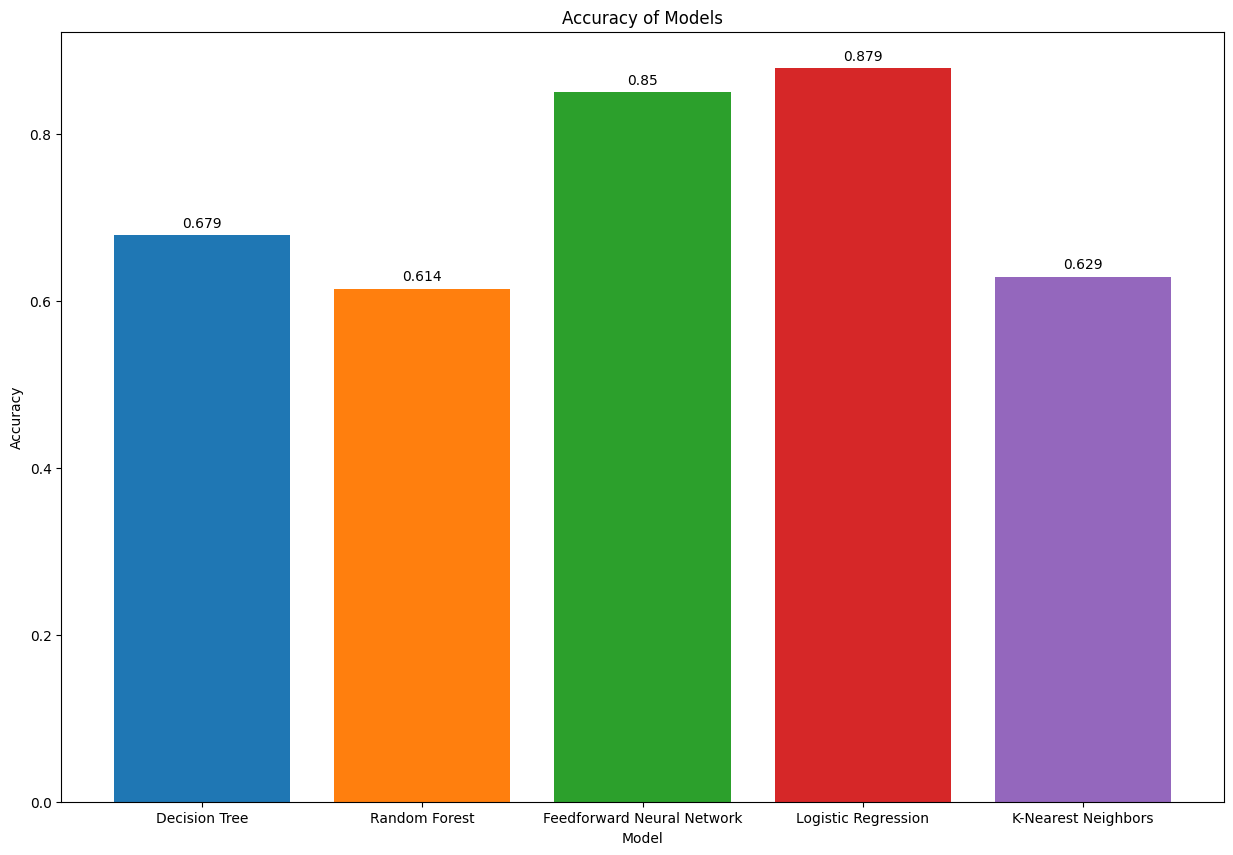

In [ ]:
import matplotlib.pyplot as plt

# Define the accuracies of the five models
accuracies = [test_score_dtc, test_score_rfc, test_score_nn, test_score_lr, test_score_knn]

# Define the labels of the five models
labels = ['Decision Tree', 'Random Forest', 'Feedforward Neural Network', 'Logistic Regression', 'K-Nearest Neighbors']

# Define the colors for the bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Set the figure size
plt.figure(figsize=(15, 10))

# Create the bar graph
plt.bar(labels, accuracies, color=colors)

#print accuracies
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, str(round(acc, 3)), horizontalalignment='center')

# Add title and axis labels
plt.title('Accuracy of Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')

# Display the graph
plt.show()